# Test to process data in Snowflake Using Python 

In [75]:
import snowflake.connector
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy.stats import boxcox
from sklearn.preprocessing import power_transform
import numpy as np
from sklearn.decomposition import PCA as SKPCA
from sklearn.cluster import KMeans
from sklearn import metrics

In [11]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\rclukey\\Documents'

In [12]:
# Set your account and login information (replace the variables with
# the necessary values). Note that ACCOUNT might also require the
# region and cloud platform where your account is located, in the form of
# '<your_account_name>.<region>.<cloud>' (e.g. 'xy12345.us-east-1.azure')
ACCOUNT = 'TRIMBLEMEP'
USER = 'bogden'
PASSWORD = 'Chi@n$lyt%cs7'

In [13]:
# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user=USER,
  password=PASSWORD,
  account=ACCOUNT,
)

In [14]:
# Using Database, Schema and Warehouse
ctx.cursor().execute('USE warehouse LOAD_WH')
ctx.cursor().execute('USE ROLE ACCOUNTADMIN')
ctx.cursor().execute('USE database QUOTE_EVENT_STRUCTURED')
ctx.cursor().execute('USE SCHEMA PUBLIC')

In [18]:
query = '''
select * from QUOTE_EVENT_STRUCTURED.PUBLIC.CONT_AGG

'''
cur = ctx.cursor().execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [19]:
df.sort_values(by=['AVG_TRX_AMT'], ascending=False)

,CONTRACTOR,CONT_STATE,CONT_ZIP,DIST_STATE_TOTAL,CNT_TRX,QUOTE_ID,REQ_UPC,CNT_MFR,CNT_DIST,AVG_ITEMS,CNT_CMDTY,MATCH_STATUS,AVG_TRX_AMT,LAST_14,FROM_TOP_10_DISTRIBUTORS
1256,PAYNE CREST ELECTRIC,MO,63132,1,2,6,362,65,5,273.44,54,0.44,23832877.05,1,3
254,ELCON CORPORATION,WA,98204,1,30,154,826,101,5,155.66,96,0.29,12023259.60,3,2
286,ENNIS ELEC CO INC,VA,20109,2,40,172,1386,78,4,317.59,97,0.87,11365199.57,1,1
719,ALL BRIGHT ELECTRIC,NY,10994,2,15,64,617,75,4,242.10,89,0.66,9274376.81,3,1
209,DIXIE ELECTRIC,OK,74012,1,1,4,4,1,1,4.00,1,0.75,9104866.54,1,0
754,AMERICAN ELECTRIC CO LLC,HI,96789,1,19,49,928,43,3,965.00,68,0.69,7722291.04,1,2
654,WILLIAM CHARLES ELECTRIC LLC,IL,61111,1,16,41,532,58,4,128.73,77,0.91,5203266.24,2,1
219,DOUBLE R CONTRACTING INC,NY,11729,1,93,224,735,56,2,93.61,77,0.82,4879720.52,6,1
67,LIMBACH COMPANY LLC,MD,20708,3,106,450,1169,85,4,148.59,89,0.66,3861192.45,8,0
310,FAITH TECHNOLOGIES,WI,54952,4,987,2627,5549,112,7,274.13,188,0.41,3795042.68,45,2


In [20]:
len(df)

1353

# Contractor Cluster Analysis Using PCA and K-Means

this python code combines the quantitative metrics for each contractor into two principal components and then identifies clusters (segments) within the data. 

In [21]:
df.dtypes

CONTRACTOR                   object
CONT_STATE                   object
CONT_ZIP                     object
DIST_STATE_TOTAL              int64
CNT_TRX                       int64
QUOTE_ID                      int64
REQ_UPC                       int64
CNT_MFR                       int64
CNT_DIST                      int64
AVG_ITEMS                   float64
CNT_CMDTY                     int64
MATCH_STATUS                float64
AVG_TRX_AMT                 float64
LAST_14                       int64
FROM_TOP_10_DISTRIBUTORS      int64
dtype: object

In [22]:
df.describe()

,DIST_STATE_TOTAL,CNT_TRX,QUOTE_ID,REQ_UPC,CNT_MFR,CNT_DIST,AVG_ITEMS,CNT_CMDTY,MATCH_STATUS,AVG_TRX_AMT,LAST_14,FROM_TOP_10_DISTRIBUTORS
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1.346000e+03,1353.000000,1353.000000
mean,1.471545,72.223208,228.067997,768.728751,47.787879,2.938655,136.328973,68.657058,0.702912,2.099980e+05,7.002217,1.521803
std,0.986280,103.695948,379.207389,979.851573,25.445093,1.684841,282.655023,37.921623,0.181641,9.781519e+05,9.223033,1.153079
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.200000e-01,1.000000,0.000000
25%,1.000000,10.000000,21.000000,270.000000,29.000000,2.000000,64.810000,42.000000,0.590000,2.570170e+03,1.000000,1.000000
50%,1.000000,40.000000,93.000000,584.000000,47.000000,3.000000,87.600000,67.000000,0.690000,3.246970e+04,4.000000,1.000000
75%,2.000000,89.000000,270.000000,992.000000,65.000000,4.000000,136.660000,94.000000,0.820000,1.183566e+05,9.000000,2.000000
max,11.000000,1016.000000,4053.000000,21365.000000,164.000000,15.000000,4673.080000,468.000000,1.000000,2.383288e+07,97.000000,6.000000


In [23]:
columns = ['CONTRACTOR','DIST_STATE_TOTAL', 'CNT_TRX','REQ_UPC', 'CNT_MFR','CNT_DIST', 'AVG_ITEMS', 'CNT_CMDTY', 'MATCH_STATUS', 'FROM_TOP_10_DISTRIBUTORS','LAST_14','AVG_TRX_AMT' ]
df1 = pd.DataFrame(df, columns=columns)

In [24]:
df1.head()
len(df1)

1353

In [25]:
def scale(y, n): 
    yr = y[y.iloc[:,1:n].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    ys = StandardScaler().fit_transform(yr.iloc[:,1:n].values)
    df_s = pd.DataFrame(ys, index=yr['CONTRACTOR'], columns=yr.iloc[:,1:n].columns)
    return df_s
#this function removes outliers and then scales the remaining data and returns a dataframe.


In [26]:
data = scale(df1, 12)

In [27]:
len(data)

1229

In [28]:
data.head()

,DIST_STATE_TOTAL,CNT_TRX,REQ_UPC,CNT_MFR,CNT_DIST,AVG_ITEMS,CNT_CMDTY,MATCH_STATUS,FROM_TOP_10_DISTRIBUTORS,LAST_14,AVG_TRX_AMT
CONTRACTOR,,,,,,,,,,,
"JTM ELECTRICAL CONTRACTORS, INC.",-0.579531,-0.248906,0.025459,0.903947,2.229639,-0.179138,0.519186,-0.354522,0.553261,-0.797206,-0.268930
JW SERVICES,-0.579531,-0.763502,-0.900449,-0.545824,-1.245160,-0.562152,-0.820817,-0.692849,-1.403452,-0.797206,-0.393195
K AND H ELECTRIC INC,-0.579531,-0.410636,-0.635378,-0.673745,-0.550200,-0.526501,-0.523038,-1.764215,-0.425096,-0.312253,-0.392046
K AND S ELECTRIC,1.024621,-0.837016,-0.986965,0.179062,0.839720,-0.709749,-0.731483,-1.482277,0.553261,-0.797206,-0.385236
K JAY ELECTRIC LTD,-0.579531,-0.778205,-0.801047,-0.503184,-0.550200,0.209937,-0.463483,-0.072584,0.553261,-0.797206,-0.230437


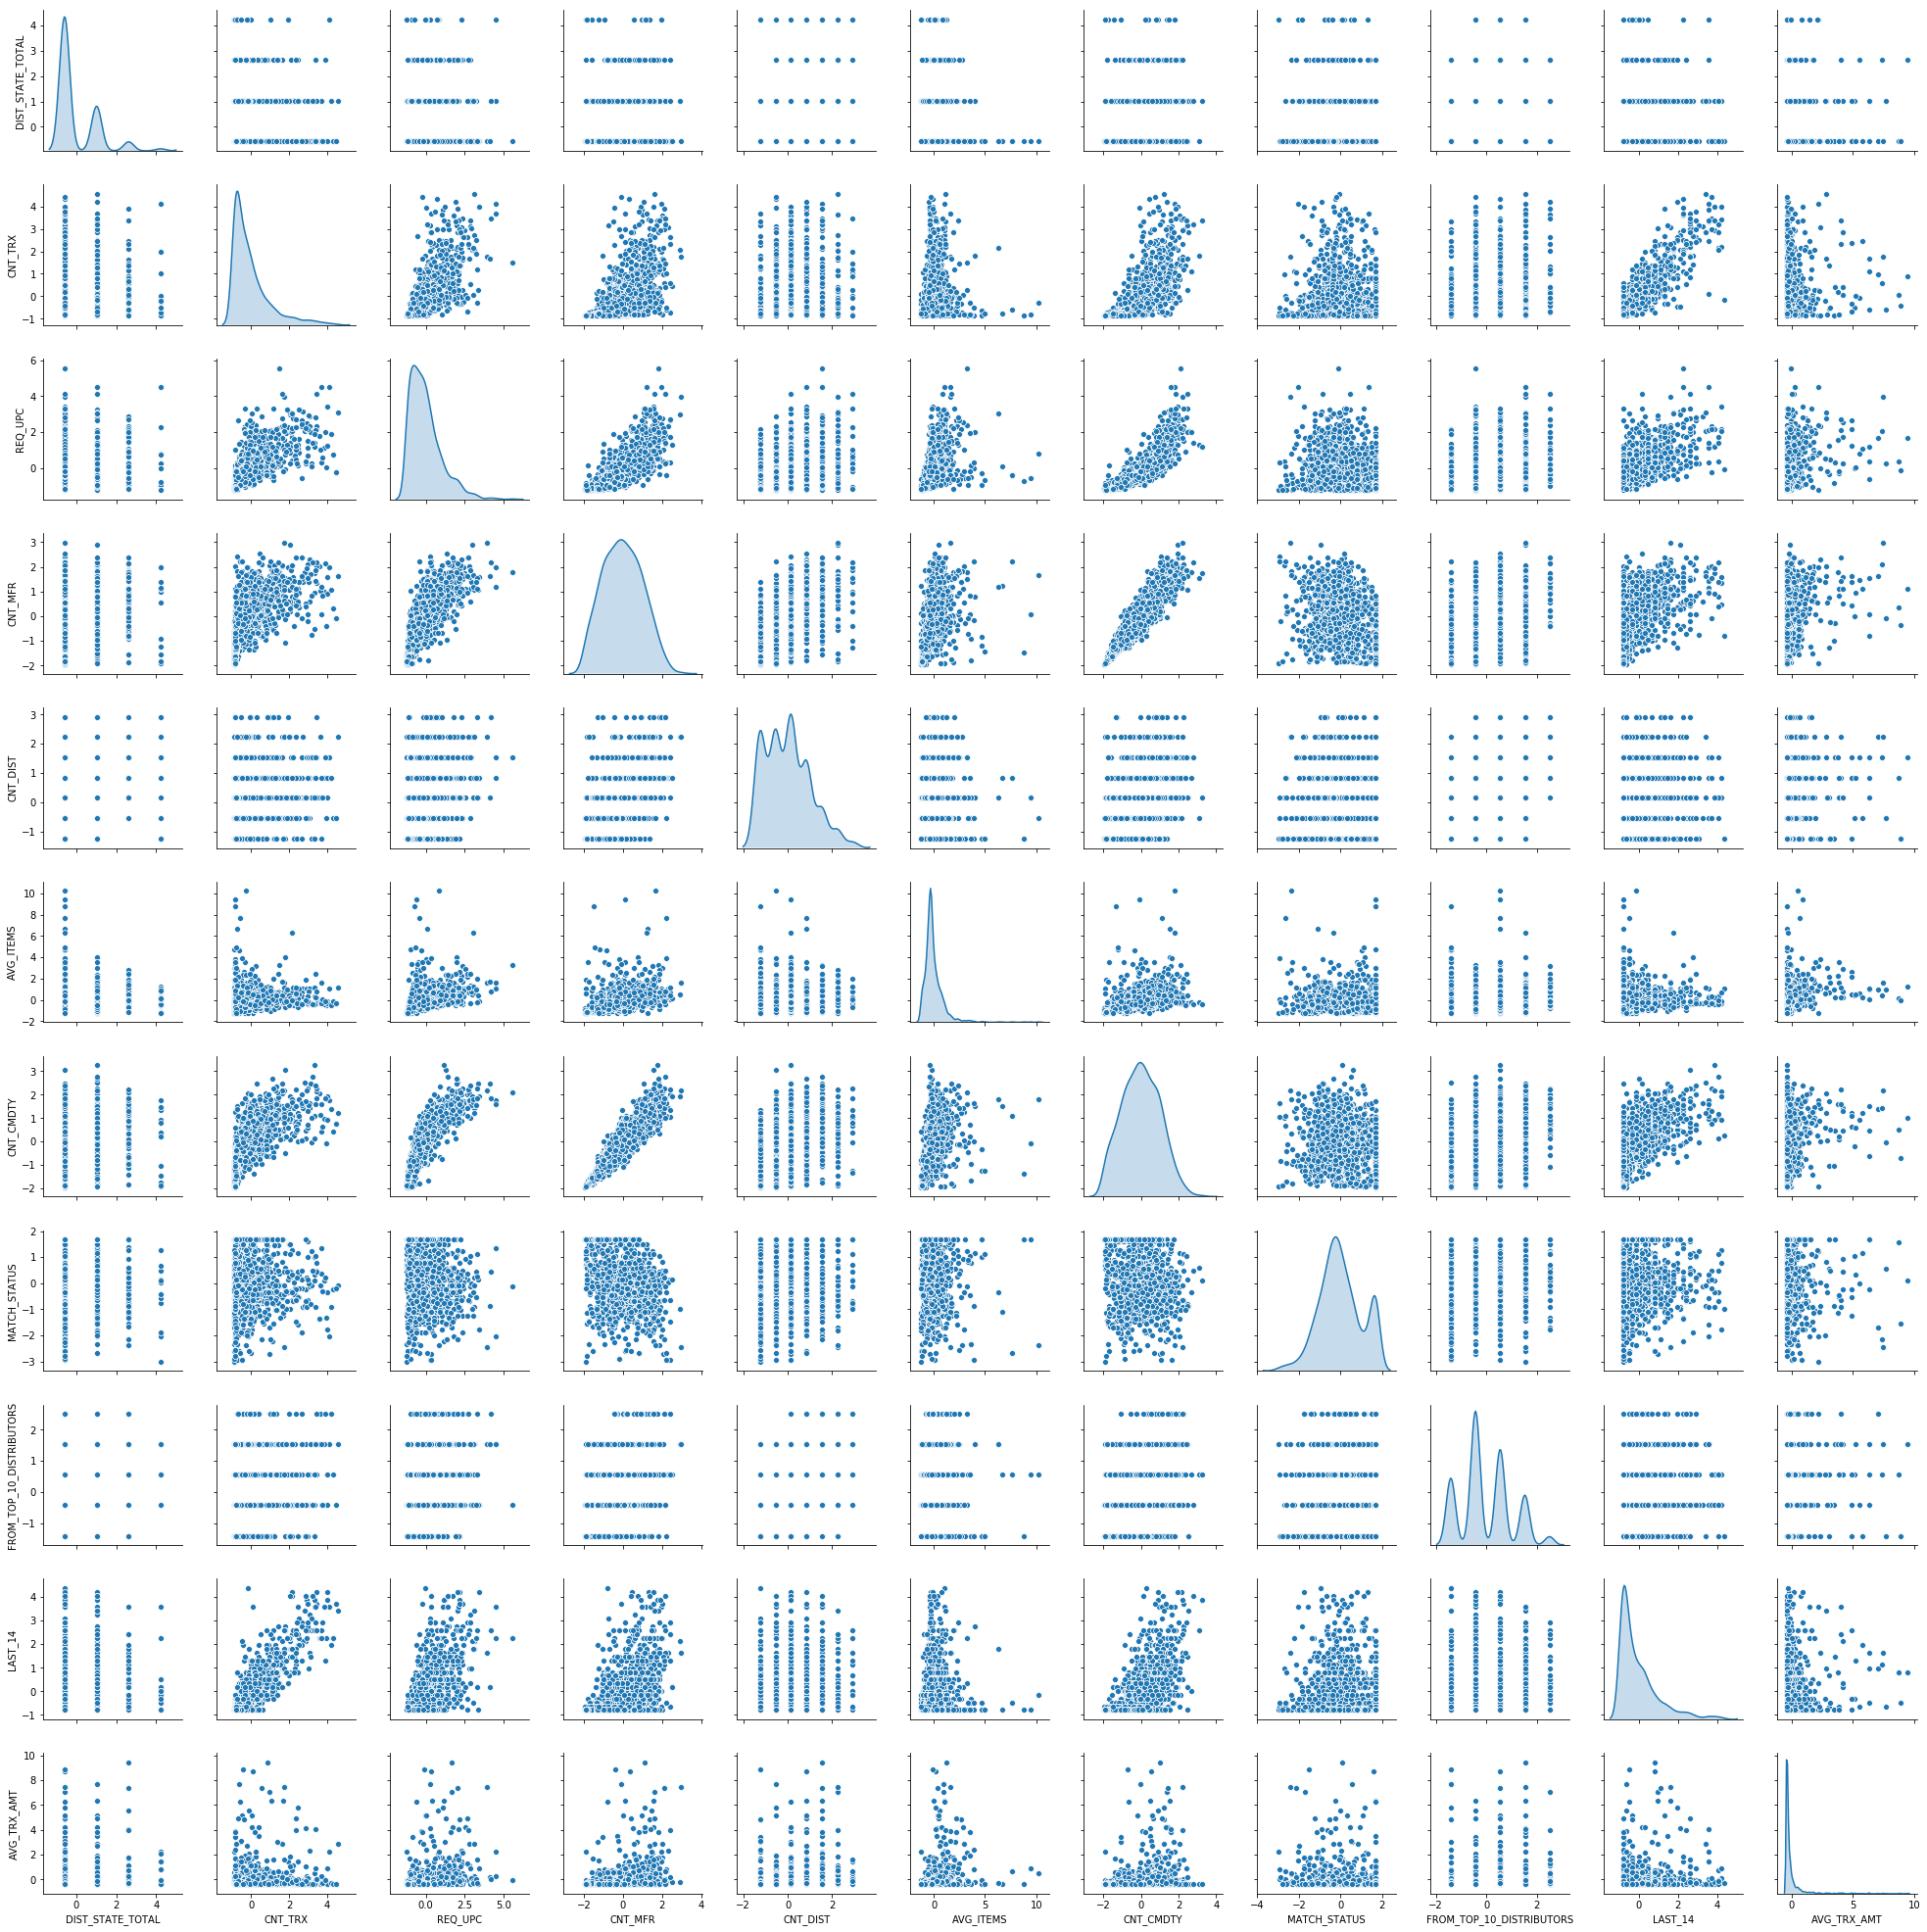

In [29]:
sns.pairplot(data, diag_kind="kde")

In [30]:
s = ['CNT_TRX','REQ_UPC','AVG_ITEMS','LAST_14','AVG_TRX_AMT']

In [37]:
def powertrns(df, iv):
    for i in iv:
        a = np.array(df[i]).reshape(-1,1)
        df[i+'_t'] = power_transform(a, method='yeo-johnson')
    return df

In [38]:
data_t = powertrns(data, s)

In [110]:
data_t.head()

,DIST_STATE_TOTAL,CNT_MFR,CNT_DIST,CNT_CMDTY,MATCH_STATUS,FROM_TOP_10_DISTRIBUTORS,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,LAST_14_t,AVG_TRX_AMT_t,cluster
CONTRACTOR,,,,,,,,,,,,
"JTM ELECTRICAL CONTRACTORS, INC.",-0.579531,0.903947,2.229639,0.519186,-0.354522,0.553261,0.087448,0.310571,0.062591,-1.123426,-0.118403,4
JW SERVICES,-0.579531,-0.545824,-1.245160,-0.820817,-0.692849,-1.403452,-1.053423,-1.078838,-0.662504,-1.123426,-0.975429,1
K AND H ELECTRIC INC,-0.579531,-0.673745,-0.550200,-0.523038,-1.764215,-0.425096,-0.216182,-0.607960,-0.586131,-0.014751,-0.966239,1
K AND S ELECTRIC,1.024621,0.179062,0.839720,-0.731483,-1.482277,0.553261,-1.259256,-1.244704,-0.998169,-1.123426,-0.912290,0
K JAY ELECTRIC LTD,-0.579531,-0.503184,-0.550200,-0.463483,-0.072584,0.553261,-1.093703,-0.895622,0.589067,-1.123426,0.096103,3


In [112]:
data_t = data_t.drop(['CNT_TRX','REQ_UPC','AVG_ITEMS','LAST_14','AVG_TRX_AMT', 'cluster'], 1)

KeyError: "['CNT_TRX' 'REQ_UPC' 'AVG_ITEMS' 'LAST_14' 'AVG_TRX_AMT'] not found in axis"

In [118]:
data_t = data_t.drop(['LAST_14_t'], 1)
data_t.head()

,CNT_MFR,CNT_DIST,CNT_CMDTY,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,AVG_TRX_AMT_t
CONTRACTOR,,,,,,,
"JTM ELECTRICAL CONTRACTORS, INC.",0.903947,2.229639,0.519186,0.087448,0.310571,0.062591,-0.118403
JW SERVICES,-0.545824,-1.245160,-0.820817,-1.053423,-1.078838,-0.662504,-0.975429
K AND H ELECTRIC INC,-0.673745,-0.550200,-0.523038,-0.216182,-0.607960,-0.586131,-0.966239
K AND S ELECTRIC,0.179062,0.839720,-0.731483,-1.259256,-1.244704,-0.998169,-0.912290
K JAY ELECTRIC LTD,-0.503184,-0.550200,-0.463483,-1.093703,-0.895622,0.589067,0.096103


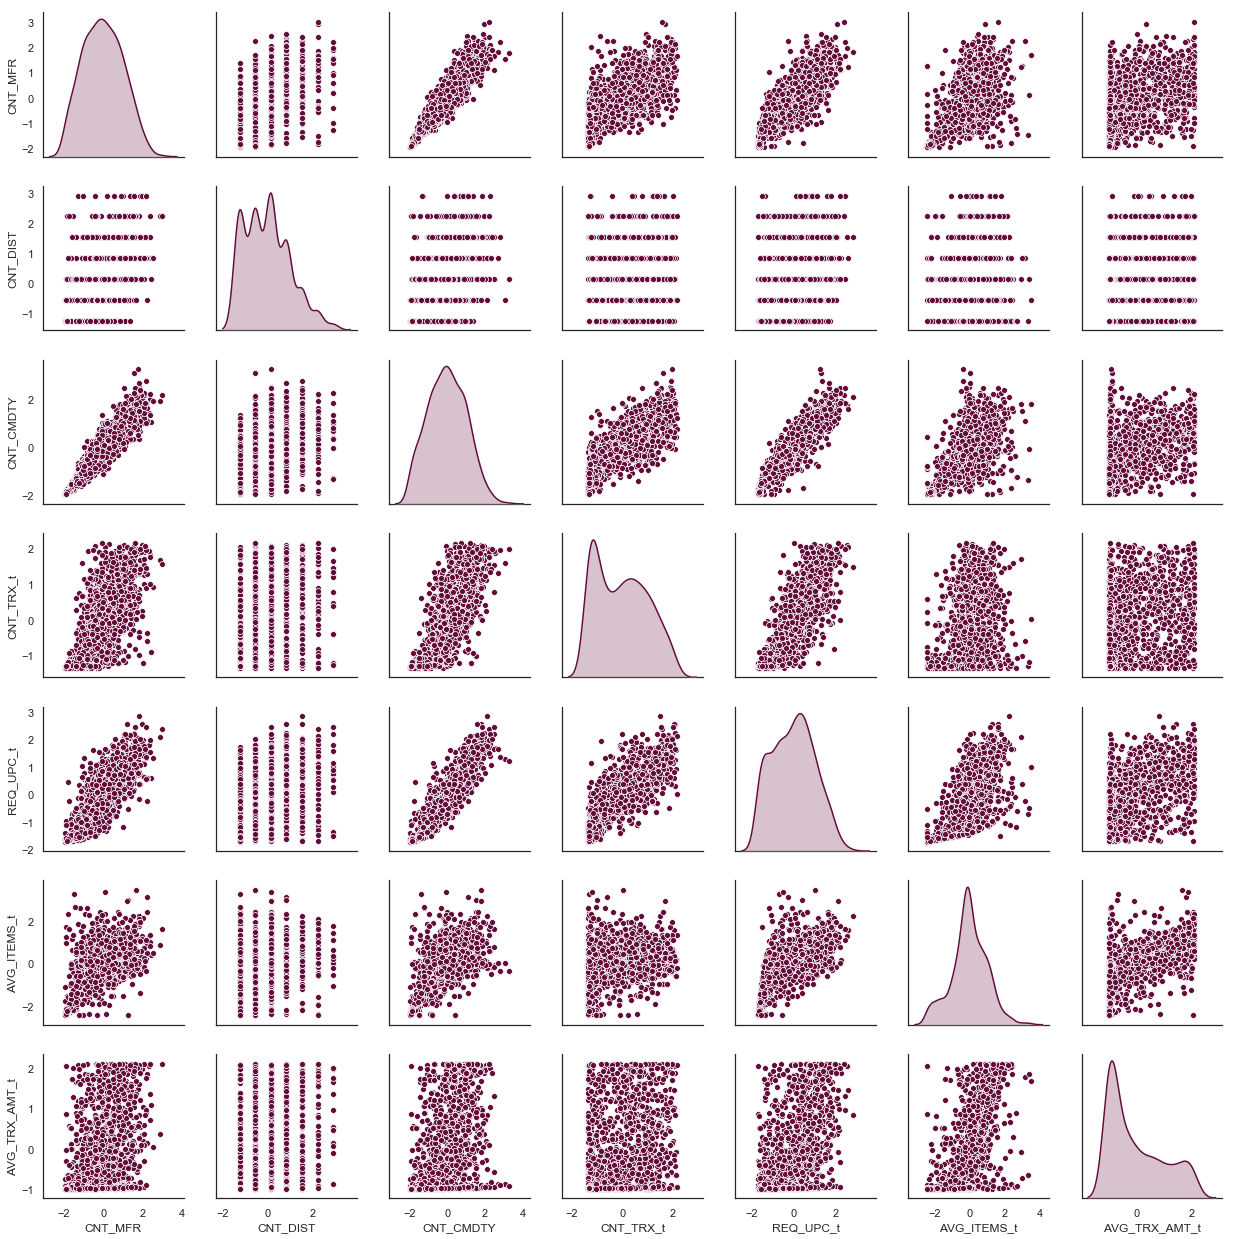

In [119]:
sns.pairplot(data_t, diag_kind="kde")

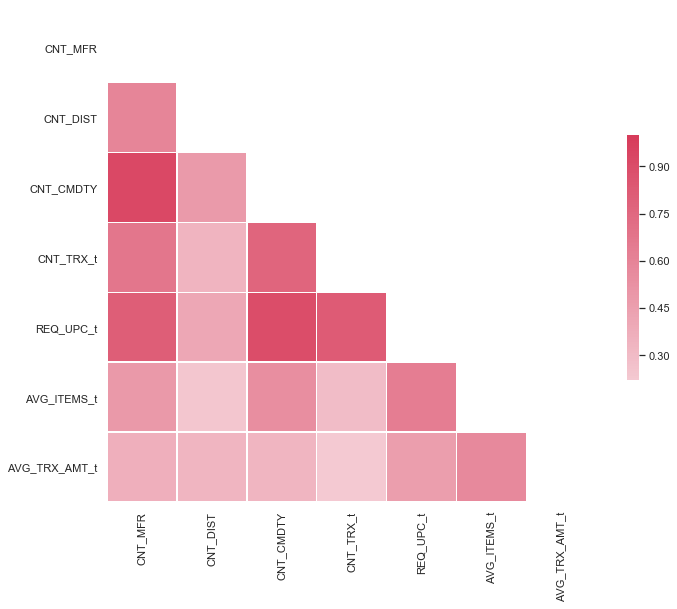

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = data_t.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 5, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [121]:
data_t.corr()

,CNT_MFR,CNT_DIST,CNT_CMDTY,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,AVG_TRX_AMT_t
CNT_MFR,1.000000,0.600285,0.921652,0.674352,0.805682,0.491049,0.360184
CNT_DIST,0.600285,1.000000,0.478136,0.342700,0.411197,0.237099,0.332231
CNT_CMDTY,0.921652,0.478136,1.000000,0.771350,0.902228,0.541180,0.336589
CNT_TRX_t,0.674352,0.342700,0.771350,1.000000,0.821101,0.294741,0.222234
REQ_UPC_t,0.805682,0.411197,0.902228,0.821101,1.000000,0.639196,0.456483
AVG_ITEMS_t,0.491049,0.237099,0.541180,0.294741,0.639196,1.000000,0.574319
AVG_TRX_AMT_t,0.360184,0.332231,0.336589,0.222234,0.456483,0.574319,1.000000


In [122]:
test_pca = SKPCA(n_components=3, svd_solver='randomized', whiten='True')
dpca = test_pca.fit_transform(data_t.iloc[:,0:11])
print(test_pca.explained_variance_ratio_) 

[0.62024848 0.15282246 0.11344272]


In [123]:
print(test_pca.explained_variance_ratio_)  #dpca.explained_variance_
dpca

[0.62024848 0.15282246 0.11344272]


array([[ 0.68696845, -0.45171472,  2.10683774],
       [-1.11569641, -0.22909451, -0.54680657],
       [-0.71483851, -0.5937643 , -0.29919486],
       ...,
       [ 0.55394897,  2.82923516,  0.10623735],
       [ 1.0948236 , -0.87812814, -0.57739413],
       [-0.23230051, -0.10915191, -0.64031305]])

In [124]:
#this is function to run Principal Component Analysis; x = data, n = number of components to extract, dv = is the DV to drop

def pca(x, n):
    pca = SKPCA(n_components=n, svd_solver='randomized', whiten='True')
    l = len(x.columns)
    x_pca = pca.fit(x.iloc[:,0:l])
    pca_t = pca.transform(x.iloc[:,0:l])
    e = pca.explained_variance_
    x_comp = pd.DataFrame(x_pca.components_.T * np.sqrt(x_pca.explained_variance_))
    x_comp['variable'] = np.array(x.columns[0:l])
    x_comp1 = pd.DataFrame(x_comp.set_index('variable'))
    x_comp2 = x_comp1.apply(lambda x: np.where(x < .2,'',round(x,2)))
    x_comp2.sort_values([0,1], ascending=False)
    var=pd.DataFrame(np.cumsum(np.round(x_pca.explained_variance_ratio_, decimals=3)*100))
    return x_comp2, var, pca_t, e

In [128]:
p, v, d, e = pca(data_t, 2)

In [129]:
e

array([4.345275  , 1.07062834])

In [130]:
p

,0,1
variable,,
CNT_MFR,0.91,
CNT_DIST,0.6,
CNT_CMDTY,0.94,
CNT_TRX_t,0.79,
REQ_UPC_t,0.95,
AVG_ITEMS_t,0.67,0.56
AVG_TRX_AMT_t,0.55,0.72


In [131]:
v

,0
0,62.0
1,77.3


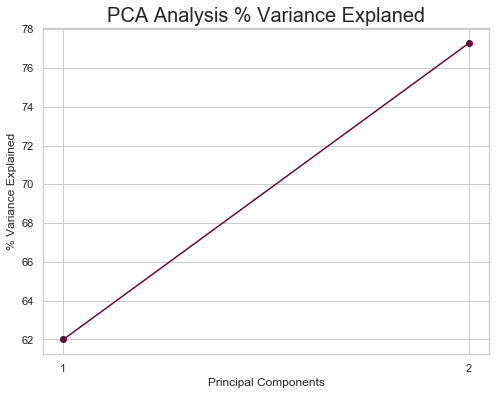

In [132]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
plt.plot(v, marker='o')
plt.xticks(np.arange(len(v)), np.arange(1, len(v)+1))
plt.title("PCA Analysis % Variance Explaned", fontdict=None, fontsize=20,loc='center', pad=None)
plt.xlabel('Principal Components') 
plt.ylabel('% Variance Explained')
plt.show()

In [52]:
d

array([[ 0.45815874,  0.87611757, -0.48571429],
       [-1.25193014, -0.74769833, -0.40255842],
       [-0.62855823, -0.77758005, -1.21207596],
       ...,
       [ 0.19387925,  0.56452118,  2.0360024 ],
       [ 1.02493868, -0.72900661, -0.02905386],
       [-0.35330095, -1.1362887 , -0.14132704]])

In [133]:
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    from scipy import eye, asarray, dot, sum, linalg
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = linalg.svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, np.diag(np.diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [134]:
dv = varimax(d)

In [135]:
dv

array([[ 0.53350793, -0.62557265],
       [-1.13528829,  0.09156022],
       [-0.85220417, -0.3705377 ],
       ...,
       [ 1.32193706,  2.56201355],
       [ 0.80606995, -1.14891209],
       [-0.2535393 , -0.0399436 ]])

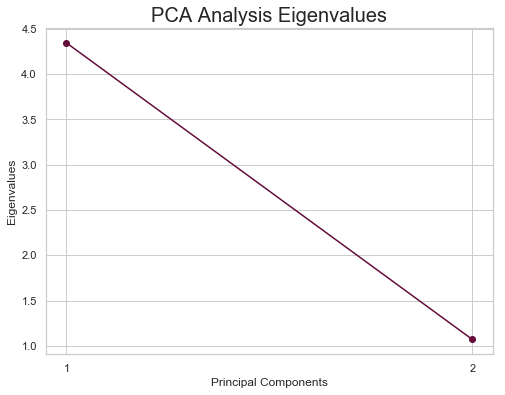

In [136]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
plt.plot(e, marker='o')
plt.xticks(np.arange(len(e)), np.arange(1, len(e)+1))
plt.title("PCA Analysis Eigenvalues", fontdict=None, fontsize=20,loc='center', pad=None)
plt.xlabel('Principal Components') 
plt.ylabel('Eigenvalues')
plt.show()

In [138]:
dv = pd.DataFrame(dv, columns = ['x','y'])
dv.head()

,x,y
0,0.533508,-0.625573
1,-1.135288,0.091560
2,-0.852204,-0.370538
3,-0.885662,-0.270588
4,-0.259775,1.154371


In [1539]:
data_all_o = pd.concat([data_t.reset_index(), pd.DataFrame(d)], axis=1)

In [1540]:
data_all_o

,CONTRACTOR,DIST_STATE_TOTAL,CNT_MFR,CNT_DIST,MATCH_STATUS,FROM_TOP_10_DISTRIBUTORS,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,LAST_14_t,AVG_TRX_AMT_t,0,1,2
0,DAVCO ELECTRICAL CONTRACTORS CORP,-0.583300,0.911138,0.116374,-0.199300,-0.439536,0.365317,0.562961,-0.028981,0.639996,-0.846750,0.332459,-1.024856,-0.355569
1,WESCAN ELECTRICAL CO,1.013517,0.654250,0.116374,0.937411,1.519352,0.828428,0.720266,-0.241613,1.141308,0.436464,0.926079,0.318146,-0.477116
2,MCCARLS INC,-0.583300,1.296470,0.806628,-1.790696,-0.439536,0.481008,0.588128,-0.566014,-0.040843,0.011392,0.487695,-0.519980,-0.781198
3,CSK ELECTRIC LLC,-0.583300,0.697065,0.806628,-0.028794,0.539908,0.516792,-0.073726,-0.039280,0.454921,-0.875402,0.366872,-0.349699,-0.762544
4,JANSEN ELECTRIC,-0.583300,-0.244857,-0.573881,0.312220,-1.418979,-0.479154,-0.576248,-0.699987,-0.721081,-0.748798,-0.898353,-0.651964,0.048788
5,DISNEY WORLDWIDE SHARED SERVICES,1.013517,0.782694,0.806628,-0.028794,1.519352,1.115999,0.547654,-0.874801,1.230997,-0.545200,0.930241,0.049347,-1.755731
6,SG CORPORATION,-0.583300,-0.715818,1.496883,0.596398,1.519352,-1.214100,-1.353734,-0.994826,-1.134298,-0.167437,-0.677598,1.680169,-0.800741
7,FETROW ELECTRIC,-0.583300,-0.844262,1.496883,1.676273,0.539908,-1.173386,-1.044428,-0.780151,-0.357088,-0.792948,-0.680284,0.923064,-0.520858
8,VIRGINIA BEACH ELECTRIC SERVICE INC,4.207152,-1.871813,2.187138,0.653233,1.519352,-1.338795,-1.752790,-2.459335,-1.134298,-0.730535,-0.837319,3.479363,-3.188612
9,B&B ELECTRICAL CONTRACTORS INC,-0.583300,-2.000257,-1.264136,1.676273,-1.418979,-1.381214,-1.741102,-2.347515,-1.134298,-0.658168,-2.147886,-0.241941,-0.079024


In [1225]:
import xlsxwriter
import xlwt
data_all_o.to_excel('data_all_o.xlsx')
#df_y.to_excel("df_y.xlsx")

In [1189]:
import os
os.getcwd()

'C:\\Users\\rclukey\\Documents'

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

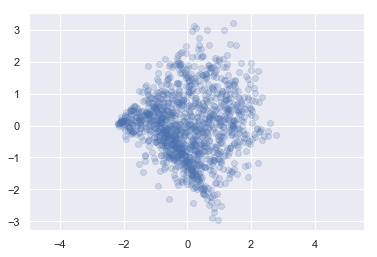

In [140]:
#def draw_vector(v0, v1, ax=None):
#    ax = ax or plt.gca()
#    arrowprops=dict(arrowstyle='->',
#                    linewidth=2,
#                    shrinkA=0, shrinkB=0)
#    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(dv.iloc[:,0],dv.iloc[:,1], alpha=0.2)
#for length, vector in zip(x_pca.explained_variance_, x_pca.components_):
#    v = vector * 3 * np.sqrt(length)
#    draw_vector(x_pca.mean_, x_pca.mean_ + v)
plt.axis('equal');

In [141]:
dv.iloc[:,0:2]

,x,y
0,0.533508,-0.625573
1,-1.135288,0.091560
2,-0.852204,-0.370538
3,-0.885662,-0.270588
4,-0.259775,1.154371
5,0.252314,1.384919
6,1.607925,0.450823
7,-0.327573,-1.143969
8,-1.333323,-1.099112
9,0.165520,-0.514557


In [142]:
dv.head()

,x,y
0,0.533508,-0.625573
1,-1.135288,0.091560
2,-0.852204,-0.370538
3,-0.885662,-0.270588
4,-0.259775,1.154371


In [143]:
dv

,x,y
0,0.533508,-0.625573
1,-1.135288,0.091560
2,-0.852204,-0.370538
3,-0.885662,-0.270588
4,-0.259775,1.154371
5,0.252314,1.384919
6,1.607925,0.450823
7,-0.327573,-1.143969
8,-1.333323,-1.099112
9,0.165520,-0.514557


In [83]:
dv.head()
dv = dv.drop('cluster', 1)
#data_t = data_t.drop('cluster', 1)

In [152]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(dv.iloc[:,0:3])
labels = kmeans.labels_
metrics.silhouette_score(dv, labels, metric='sqeuclidean')

0.5686764191368291

In [153]:
t_kmeans = KMeans(n_clusters=3, random_state=42, init='random',algorithm='elkan', max_iter=20, n_init=10)
t_kmeans.fit_predict(dv)
metrics.silhouette_score(dv, labels, metric='sqeuclidean')

0.5686764191368291

In [1543]:
do = pd.DataFrame(d, columns = ['x','y','z'])

In [154]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(dv)
    kmeanModel.fit(dv)
    distortions.append(sum(np.min(cdist(dv, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dv.shape[0])

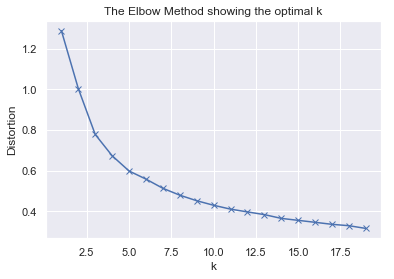

In [155]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [156]:
dv['cluster'] = pd.Series(labels, index=dv.index)

In [157]:
dv.head()

,x,y,cluster
0,0.533508,-0.625573,2
1,-1.135288,0.091560,1
2,-0.852204,-0.370538,1
3,-0.885662,-0.270588,1
4,-0.259775,1.154371,1


In [1564]:
#d_o = pd.DataFrame(d, columns = ['x','y','z'])
#d_o['cluster'] = pd.Series(y_kmeans, index=d_o.index)
do['cluster'] = pd.Series(labels, index=do.index)

In [1565]:
do.head()

,x,y,z,cluster
0,0.332459,-1.024856,-0.355569,1
1,0.926079,0.318146,-0.477116,2
2,0.487695,-0.519980,-0.781198,1
3,0.366872,-0.349699,-0.762544,1
4,-0.898353,-0.651964,0.048788,0


c:\users\rclukey\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
c:\users\rclukey\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\rclukey\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


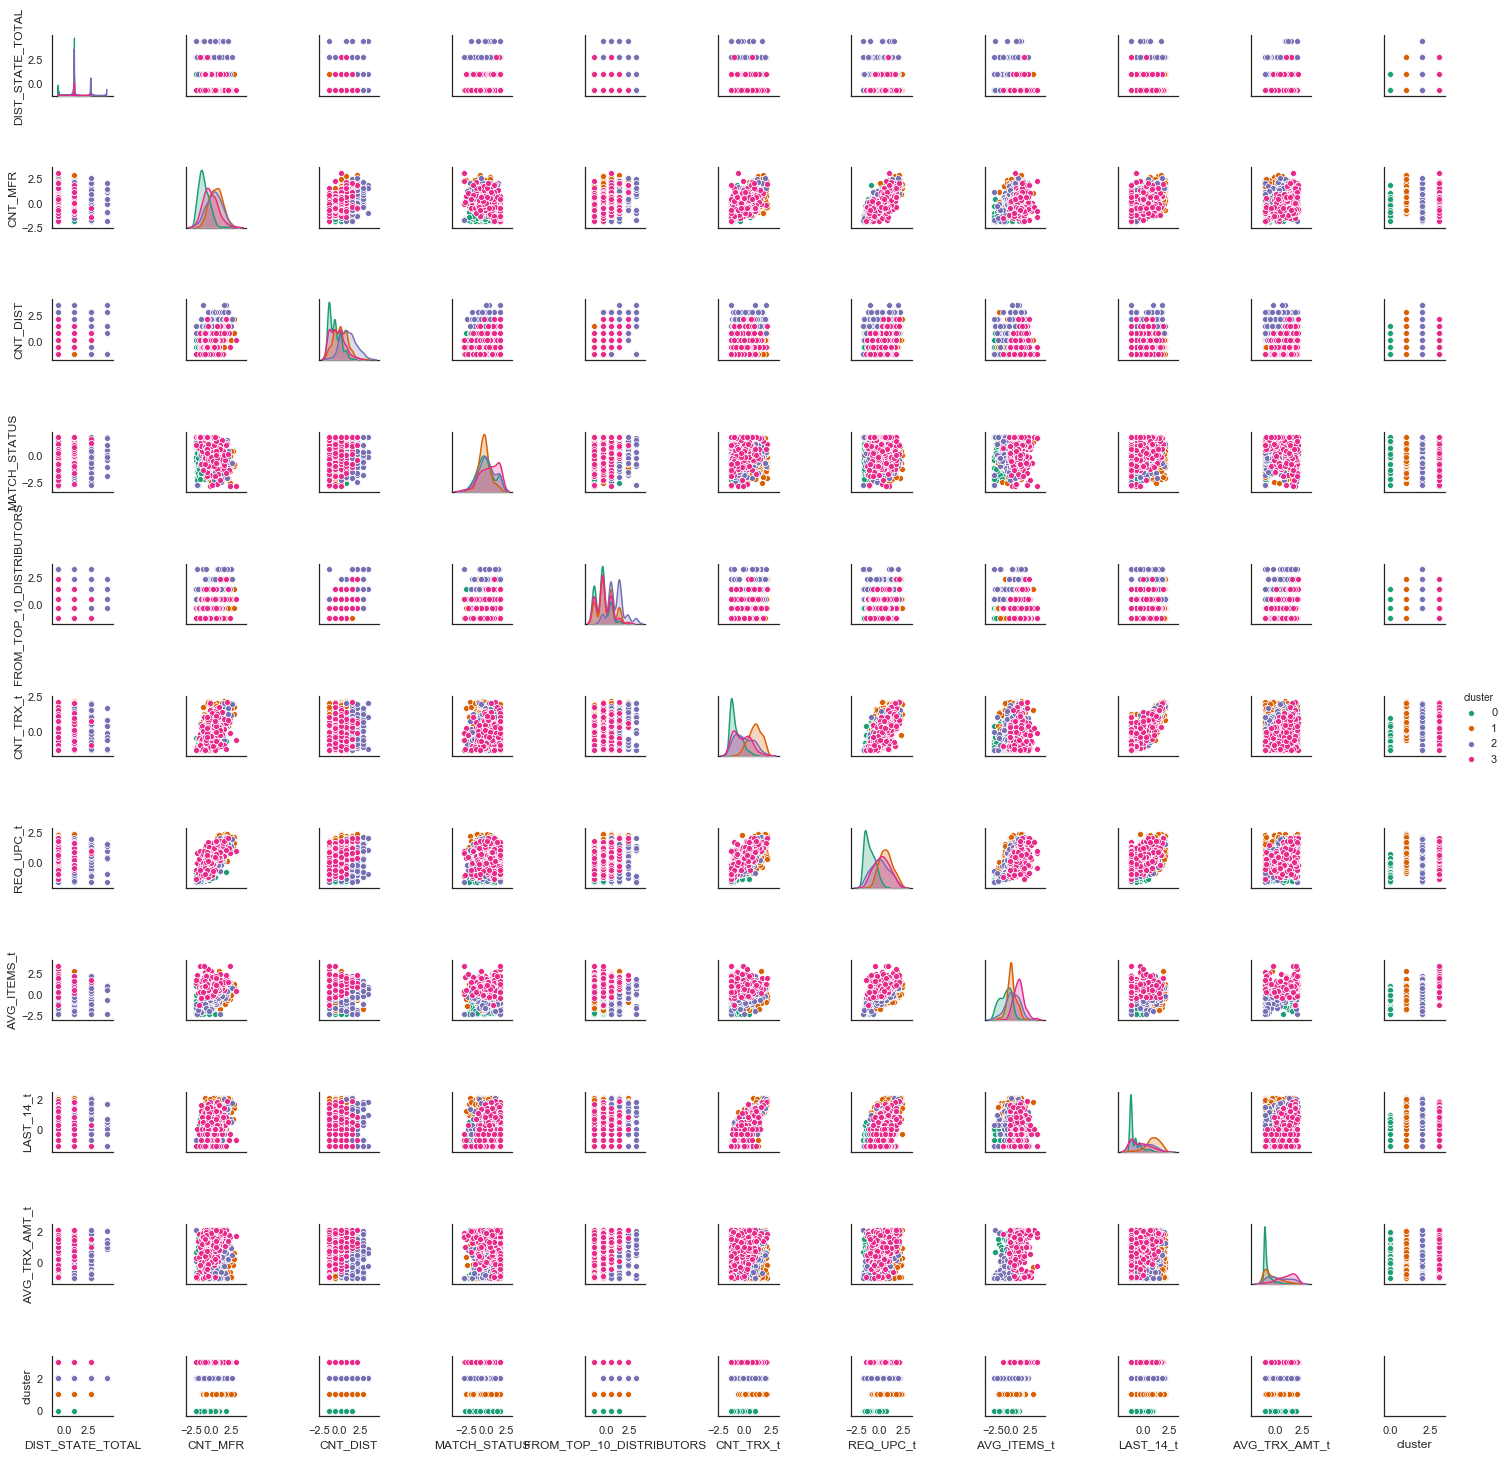

In [1498]:
sns.pairplot(data_t, hue='cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

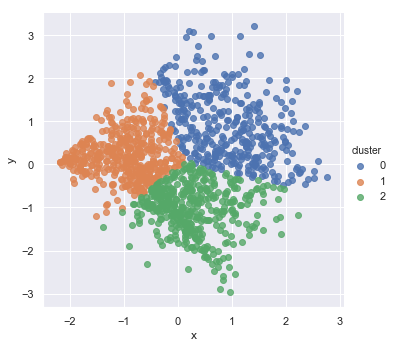

In [158]:
#plot data with seaborn
facet = sns.lmplot(data=dv, x='x', y='y', hue='cluster', 
                   fit_reg=False, legend=True, legend_out=True)

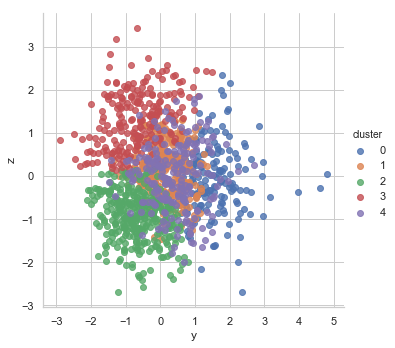

In [91]:
#plot data with seaborn
facet = sns.lmplot(data=dv, x='y', y='z', hue='cluster', 
                   fit_reg=False, legend=True, legend_out=True)

In [1468]:
dv_m = dv.groupby('cluster').mean()


In [1470]:
dv_center = dv_m.T
dv_center

cluster,0,1,2,3
x,-1.106050,0.516055,0.561823,0.316819
y,0.028325,-0.903236,1.278753,0.070710
z,-0.098995,-0.520705,-0.503858,1.413307


In [92]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

x = dv['x']
y = dv['y']
z = dv['z']
ax.scatter(x, y, z, s=50, alpha=0.6, edgecolors='w', c=dv['cluster'])

ax.set_xlabel('trx_vol')
ax.set_ylabel('dist_reach')
ax.set_zlabel('trx_vale')

plt.show()

TypeError: 'module' object is not callable

In [159]:
dv.groupby(['cluster']).mean()

,x,y
cluster,,
0,0.930083,0.896615
1,-0.987613,0.236143
2,0.263157,-1.019403


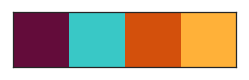

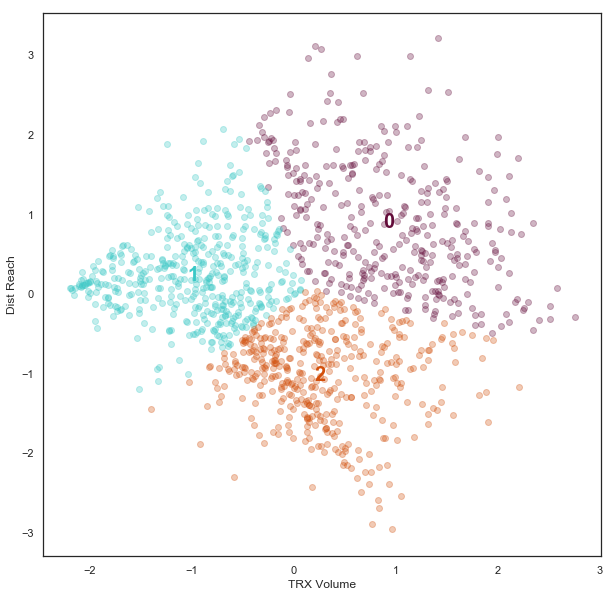

In [162]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#create a new figure
plt.figure(figsize=(10,10))

groups = (0, 1, 2)

#loop through labels and plot each cluster
for i, label in enumerate(groups):

    #add data points 
    plt.scatter(x=dv.loc[dv['cluster']==label,'x'], 
                y=dv.loc[dv['cluster']==label,'y'], 
                color=customPalette[i], 
                alpha=0.30)
    
    #add label
    plt.annotate(label, 
                 dv.loc[dv['cluster']==label,['x','y']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color=customPalette[i]) 
    
    plt.xlabel('TRX Volume')
    plt.ylabel('Dist Reach')

TypeError: 'module' object is not callable

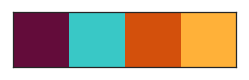

In [95]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#create a new figure
plt.figure(figsize=(10,10))

groups = (0,1,2,3,4)

#loop through labels and plot each cluster
for i, label in enumerate(groups):

    #add data points 
    plt.scatter(x=dv.loc[dv['cluster']==label,'x'], 
                y=dv.loc[dv['cluster']==label,'z'], 
                color=customPalette[i], 
                alpha=0.30)
    
    #add label
    plt.annotate(label, 
                 dv.loc[dv['cluster']==label,['x','z']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color=customPalette[i]) 
    
    plt.xlabel('TRX Volume')
    plt.ylabel('TRX Value')

In [163]:
#data_t = data_t.drop('cluster', 1)
#df1['cluster'] = pd.Series(y_kmeans+1, index=df1.index)
data_t['cluster'] = pd.Series(labels, index=data_t.index)

In [164]:
data_t.head()

,CNT_MFR,CNT_DIST,CNT_CMDTY,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,AVG_TRX_AMT_t,cluster
CONTRACTOR,,,,,,,,
"JTM ELECTRICAL CONTRACTORS, INC.",0.903947,2.229639,0.519186,0.087448,0.310571,0.062591,-0.118403,2
JW SERVICES,-0.545824,-1.245160,-0.820817,-1.053423,-1.078838,-0.662504,-0.975429,1
K AND H ELECTRIC INC,-0.673745,-0.550200,-0.523038,-0.216182,-0.607960,-0.586131,-0.966239,1
K AND S ELECTRIC,0.179062,0.839720,-0.731483,-1.259256,-1.244704,-0.998169,-0.912290,1
K JAY ELECTRIC LTD,-0.503184,-0.550200,-0.463483,-1.093703,-0.895622,0.589067,0.096103,1


In [96]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

In [97]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [98]:
dv.groupby(['cluster']).mean()

,x,y,z
cluster,,,
0,-0.092557,1.566706,-0.103149
1,-1.150092,0.144849,0.154677
2,0.035156,-0.679341,-0.941339
3,0.218430,-0.694569,1.312034
4,1.389114,0.385650,-0.032810


In [165]:
#formula = 'DIST_STATE_TOTAL + CNT_TRX + REQ_UPC + CNT_MFR + CNT_DIST + AVG_ITEMS + MATCH_STATUS + AVG_TRX_AMT ~ C(cluster)'
formula = 'AVG_TRX_AMT_t ~ C(cluster)'
model = ols(formula, data_t).fit()
aov_table = anova_lm(model, typ=2)

In [166]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(cluster),769.128515,2.0,1025.233777,1.999213e-262,0.625817,0.625015
Residual,459.871485,1226.0,NaN,NaN,NaN,NaN


In [167]:
mod = ols('AVG_TRX_AMT_t ~ C(cluster)',data=data_t).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                sum_sq      df            F         PR(>F)
C(cluster)  769.128515     2.0  1025.233777  1.999213e-262
Residual    459.871485  1226.0          NaN            NaN


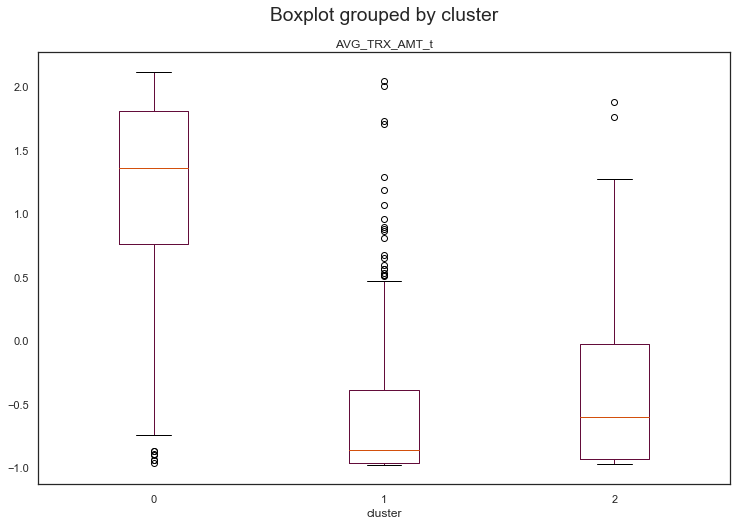

In [168]:
#Create a boxplot
data_t.boxplot('AVG_TRX_AMT_t', by='cluster', figsize=(12, 8), grid=False)

In [106]:
data_t.groupby('cluster').median()

,DIST_STATE_TOTAL,CNT_MFR,CNT_DIST,CNT_CMDTY,MATCH_STATUS,FROM_TOP_10_DISTRIBUTORS,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,LAST_14_t,AVG_TRX_AMT_t
cluster,,,,,,,,,,,
0,1.024621,-0.204701,0.14476,-0.582594,-0.241747,0.553261,-0.935224,-0.885676,-0.650675,-1.123426,-0.688777
1,-0.579531,-0.972227,-1.24516,-0.910150,-0.100778,-0.425096,-1.053423,-1.035725,-0.684218,-1.123426,-0.939155
2,-0.579531,0.562825,0.14476,0.638297,-0.354522,-0.425096,0.883538,0.556814,-0.055473,0.947867,-0.602396
3,-0.579531,-0.417903,-0.55020,-0.165704,1.280722,-0.425096,-0.501464,0.085634,0.899789,-0.333844,0.946448
4,1.024621,1.031868,0.83972,0.876520,-0.072584,1.531618,0.667213,0.892919,0.683787,0.664910,1.042004


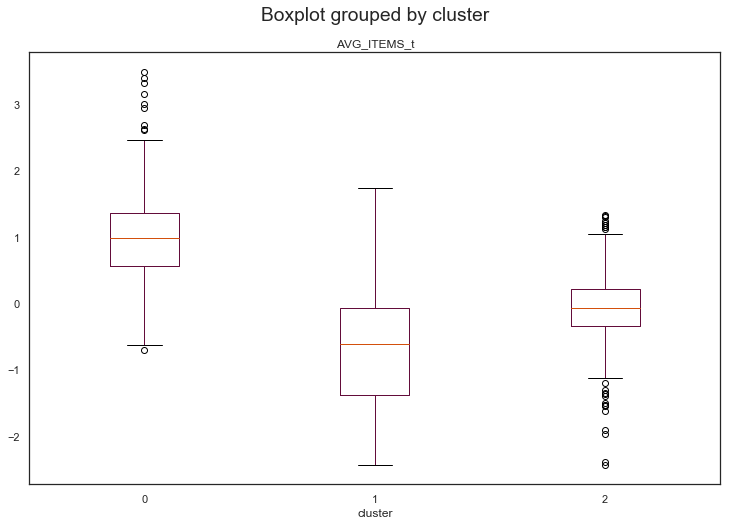

In [169]:
data_t.boxplot('AVG_ITEMS_t', by='cluster', figsize=(12, 8), grid=False)

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [475]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='AVG_TRX_AMT_t ~ FROM_TOP_10_DISTRIBUTORS + CNT_TRX_t + REQ_UPC + CNT_MFR + CNT_DIST + AVG_ITEMS_t + MATCH_STATUS', data=data_t).fit()
#print(lm.params)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AVG_TRX_AMT_t   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     125.7
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          3.16e-139
Time:                        15:05:15   Log-Likelihood:                -1417.2
No. Observations:                1234   AIC:                             2850.
Df Residuals:                    1226   BIC:                             2891.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7.459e-17      0.022  -3.42e-15      1.000      -0.043       0.043
FROM_TOP_10_DISTRIBUTORS     0.0820      0.028      2.913      0.004       0.027       0.137
CNT_TRX_t                   -0.1777      0.039     -4.540      0.000      -0.255      -0.101
REQ_UPC                      0.1813      0.045      4.014      0.000       0.093       0.270
CNT_MFR                     -0.0484      0.047     -1.023      0.307      -0.141       0.044
CNT_DIST                     0.0926      0.033      2.784      0.005       0.027       0.158
AVG_ITEMS_t                  0.5556      0.030     18.451      0.000       0.497       0.615
MATCH_STATUS                 0.0016      0.026      0.062      0.950      -0.049       0.052
==============================================================================
Omnibus:                       58.479   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.494
Skew:                           0.516   Prob(JB):                     2.21e-15
Kurtosis:                       3.498   Cond. No.                         4.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

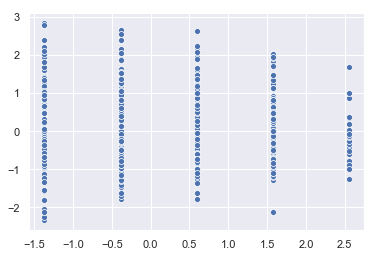

In [476]:
sns.scatterplot(lm.model.exog[:,1], lm.resid)

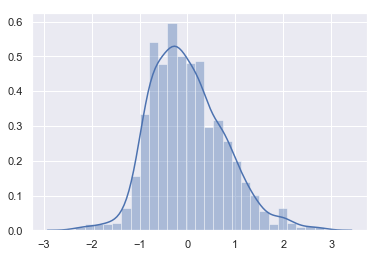

In [477]:
sns.set_style('darkgrid')
sns.distplot(lm.resid)

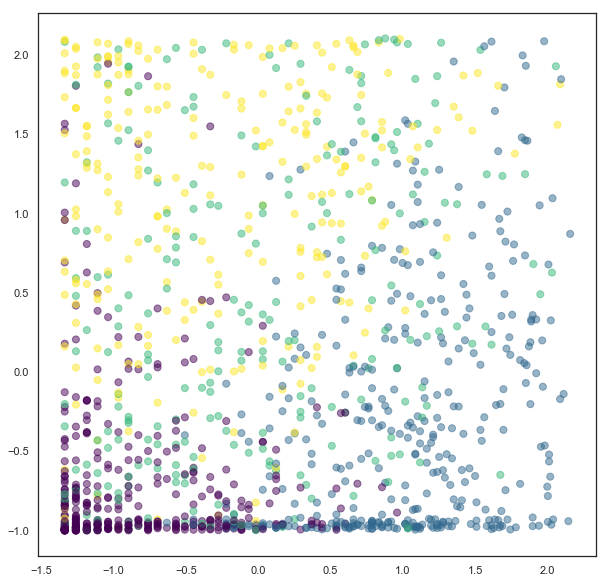

In [1497]:
figure(figsize=(10,10))
#plt.scatter(data_s['CNT_TRX'], data_s['AVG_TRX_AMT'], c=data_s['cluster'], s=50, cmap='viridis', alpha=.5)
plt.pyplot.scatter(data_t['CNT_TRX_t'], data['AVG_TRX_AMT_t'], c=data['cluster'], s=50, cmap='viridis', alpha=.5)

In [314]:
df.groupby(['month_year'])['QUOTEID', 'DISTRIBUTOR_COMPANY_NAME', 'CONTRACTOR_COMPANY_NAME'].nunique()

,QUOTEID,DISTRIBUTOR_COMPANY_NAME,CONTRACTOR_COMPANY_NAME
month_year,,,
2018-10-01/2018-10-07,16311,140,793
2018-10-08/2018-10-14,16294,147,788
2018-10-15/2018-10-21,16813,149,806
2018-10-22/2018-10-28,17016,141,787
2018-10-29/2018-11-04,16440,146,813
2018-11-05/2018-11-11,16394,143,799
2018-11-12/2018-11-18,15965,144,782
2018-11-19/2018-11-25,9582,143,667
2018-11-26/2018-12-02,15798,150,823


In [293]:
dist_cnt['Percentile_rank']=dist_cnt.QUOTEID.rank(pct=True)
dist_cnt['Percent_total']=dist_cnt.QUOTEID / dist_cnt.QUOTEID.sum()
dist_cnt['cumulative%']=dist_cnt.Percent_total.cumsum()
dist_cnt

,QUOTEID,Percentile_rank,Percent_total,cumulative%
DISTRIBUTOR_COMPANY_NAME,,,,
GRAYBAR ELECTRIC COMPANY INC,71924,1.000000,0.175779,0.175779
AVERAGE MARKET PRICE - ELECTRICAL,39981,0.994253,0.097711,0.273490
CED,24468,0.988506,0.059799,0.333289
"MONOSYSTEMS - Manufacturer Direct Pricing on cable tray, surface raceway, poke throughs, j",17176,0.982759,0.041977,0.375266
REXEL,15984,0.977011,0.039064,0.414330
GEXPRO,12277,0.971264,0.030004,0.444334
WESCO,11206,0.965517,0.027387,0.471721
EECOL ELECTRIC,10108,0.959770,0.024703,0.496425
WESCO DISTRIBUTION,10069,0.954023,0.024608,0.521033


In [317]:
st_cnt = df.groupby(['DISTRIBUTOR_STATE'])['DISTRIBUTOR_COMPANY_NAME', 'QUOTEID'].nunique()
st_cnt = pd.DataFrame(st_cnt)
st_cnt['dq_ratio'] = st_cnt['QUOTEID']/st_cnt['DISTRIBUTOR_COMPANY_NAME']
st_cnt.sort_values(['DISTRIBUTOR_COMPANY_NAME'],ascending=False)

,DISTRIBUTOR_COMPANY_NAME,QUOTEID,dq_ratio
DISTRIBUTOR_STATE,,,
IL,21,18309,871.857143
CA,20,20417,1020.850000
TX,18,29691,1649.500000
OH,15,14866,991.066667
NY,15,28261,1884.066667
MI,15,12331,822.066667
PA,14,11502,821.571429
GA,13,3173,244.076923
CO,12,17045,1420.416667


In [170]:
data = data_t.reset_index()

In [171]:
data_t.head()

,CNT_MFR,CNT_DIST,CNT_CMDTY,CNT_TRX_t,REQ_UPC_t,AVG_ITEMS_t,AVG_TRX_AMT_t,cluster
CONTRACTOR,,,,,,,,
"JTM ELECTRICAL CONTRACTORS, INC.",0.903947,2.229639,0.519186,0.087448,0.310571,0.062591,-0.118403,2
JW SERVICES,-0.545824,-1.245160,-0.820817,-1.053423,-1.078838,-0.662504,-0.975429,1
K AND H ELECTRIC INC,-0.673745,-0.550200,-0.523038,-0.216182,-0.607960,-0.586131,-0.966239,1
K AND S ELECTRIC,0.179062,0.839720,-0.731483,-1.259256,-1.244704,-0.998169,-0.912290,1
K JAY ELECTRIC LTD,-0.503184,-0.550200,-0.463483,-1.093703,-0.895622,0.589067,0.096103,1


In [172]:
dfr_seg = data[['CONTRACTOR', 'cluster']]
dfr_seg.head()

,CONTRACTOR,cluster
0,"JTM ELECTRICAL CONTRACTORS, INC.",2
1,JW SERVICES,1
2,K AND H ELECTRIC INC,1
3,K AND S ELECTRIC,1
4,K JAY ELECTRIC LTD,1


In [173]:
len(dfr_seg)

1229

In [174]:
dfr_seg.to_csv('dfr.csv', sep='|')
ctx.cursor().execute('USE database QUOTE_EVENT_STRUCTURED')
ctx.cursor().execute(
    'CREATE OR REPLACE TABLE '
    'cont_segment(index integer, contractor string, cluster integer)')
#con.cursor().execute("PUT file:c:/Users/rclukey/Documents/pd_sf_test.csv @%testtable")
ctx.cursor().execute("PUT file://dfr.csv @%cont_segment")
ctx.cursor().execute("COPY INTO cont_segment FILE_FORMAT=(TYPE= 'CSV' skip_header = 1 FIELD_DELIMITER='|')")


In [175]:
query = '''
select * from QUOTE_EVENT_STRUCTURED.PUBLIC.contractor_aggregate

'''
cur = ctx.cursor().execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

ProgrammingError: 002003 (42S02): SQL compilation error:
Object 'QUOTE_EVENT_STRUCTURED.PUBLIC.CONTRACTOR_AGGREGATE' does not exist.

In [1696]:
query = '''
select * from QUOTE_EVENT_STRUCTURED.PUBLIC."3M_TRX"

'''
cur = ctx.cursor().execute(query)
df_3m = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [1697]:
df_3m.head()

,MFR,TX_ID,CNT_DIST,AVG_QUANTITY,ITEM_CNT,AVG_TX_AMT,AVG_MATCH,MAX_PRICE
0,3M,94123,2,1.0,3,14.03,0.4,24.560
1,3M,92800,1,61.0,1,14.03,1.0,22.764
2,3M,51022,2,1.0,3,14.03,0.4,24.560
3,3M,98854,2,1.0,3,14.03,0.4,24.560
4,3M,71449,2,1.0,3,14.03,0.4,24.560


In [1698]:
d3 = df_3m.drop(['MFR', 'TX_ID'], 1)

In [1699]:
d3.head()

,CNT_DIST,AVG_QUANTITY,ITEM_CNT,AVG_TX_AMT,AVG_MATCH,MAX_PRICE
0,2,1.0,3,14.03,0.4,24.560
1,1,61.0,1,14.03,1.0,22.764
2,2,1.0,3,14.03,0.4,24.560
3,2,1.0,3,14.03,0.4,24.560
4,2,1.0,3,14.03,0.4,24.560


In [1700]:
d3.dtypes

CNT_DIST          int64
AVG_QUANTITY    float64
ITEM_CNT          int64
AVG_TX_AMT      float64
AVG_MATCH       float64
MAX_PRICE       float64
dtype: object

In [1690]:
d3.head()

,CNT_DIST,AVG_QUANTITY,ITEM_CNT,AVG_TX_AMT,AVG_MATCH,MAX_PRICE
0,2,1.0,3,14.03,0.4,24.560
1,1,61.0,1,14.03,1.0,22.764
2,2,1.0,3,14.03,0.4,24.560
3,2,1.0,3,14.03,0.4,24.560
4,2,1.0,3,14.03,0.4,24.560


In [1701]:
from scipy import stats
dfs = d3[(np.abs(stats.zscore(d3)) < 3).all(axis=1)]

In [1702]:
len(dfs)

27349

In [1703]:
dfs.head()

,CNT_DIST,AVG_QUANTITY,ITEM_CNT,AVG_TX_AMT,AVG_MATCH,MAX_PRICE
0,2,1.0,3,14.03,0.4,24.560
1,1,61.0,1,14.03,1.0,22.764
2,2,1.0,3,14.03,0.4,24.560
3,2,1.0,3,14.03,0.4,24.560
4,2,1.0,3,14.03,0.4,24.560


In [1686]:
def scale(y, n): 
    yr[keep] = y[y.iloc[:,0:n].apply(lambda x: np.abs((x - x.mean()) / x.std()) < 3).all(axis=1)]
    ys = StandardScaler().fit_transform(yr.iloc[:,0:n].values)
    df_s = pd.DataFrame(ys, columns=yr.iloc[:,0:n].columns)
    return df_s

In [ ]:
df3 = result[~(result['Value'] <= 10)]  
df['keep'] = df.apply(lambda row: sum(any([(x < 10) or (x > 25) for x in row])), axis = 1)

In [1716]:
d3s = scale(dfs, 6)

In [1717]:
len(d3s)

25530

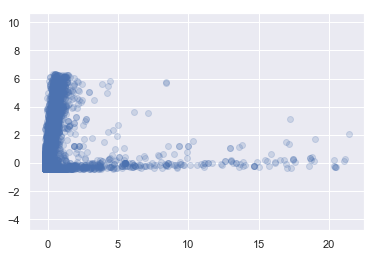

In [1734]:
plt.scatter(d3s['AVG_TX_AMT'],d3s['AVG_QUANTITY'], alpha=0.2)
#for length, vector in zip(x_pca.explained_variance_, x_pca.components_):
#    v = vector * 3 * np.sqrt(length)
#    draw_vector(x_pca.mean_, x_pca.mean_ + v)
plt.axis('equal');

In [1720]:
test_pca = SKPCA(n_components=3, svd_solver='randomized', whiten='True')
dpca = test_pca.fit_transform(d3s)
print(test_pca.explained_variance_ratio_) 

[0.26504228 0.20775594 0.1679052 ]


In [1721]:
df_3s = pd.DataFrame(dpca, columns=['D1','D2', 'D3'])

In [1722]:
df_3s.head()

,D1,D2,D3
0,0.488016,-0.146994,-0.528165
1,-0.782317,-0.272592,0.345455
2,0.488016,-0.146994,-0.528165
3,0.488016,-0.146994,-0.528165
4,0.488016,-0.146994,-0.528165


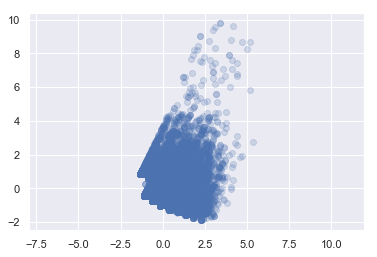

In [1723]:
plt.scatter(df_3s['D1'],df_3s['D2'], alpha=0.2)
#for length, vector in zip(x_pca.explained_variance_, x_pca.components_):
#    v = vector * 3 * np.sqrt(length)
#    draw_vector(x_pca.mean_, x_pca.mean_ + v)
plt.axis('equal');

In [1724]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(df_3s)
    kmeanModel.fit(df_3s)
    distortions.append(sum(np.min(cdist(df_3s, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_3s.shape[0])

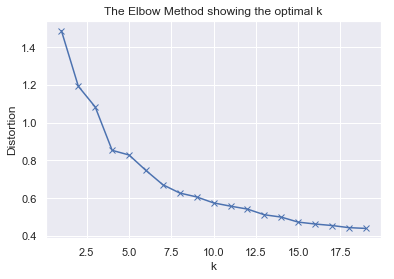

In [1725]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [1730]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(df_3s)
labels = kmeans.labels_
metrics.silhouette_score(df_3s, labels, metric='sqeuclidean')

0.6211657435578627

In [1731]:
df_3s['cluster'] = pd.Series(labels, index=df_3s.index)

In [1732]:
df_3s.head()

,D1,D2,D3,cluster
0,0.488016,-0.146994,-0.528165,3
1,-0.782317,-0.272592,0.345455,0
2,0.488016,-0.146994,-0.528165,3
3,0.488016,-0.146994,-0.528165,3
4,0.488016,-0.146994,-0.528165,3


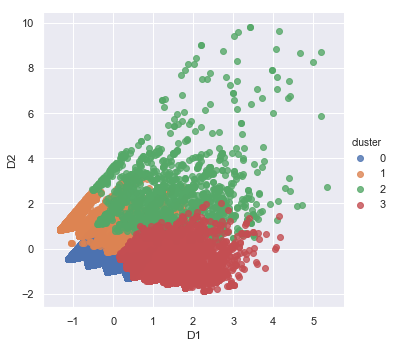

In [1733]:
#plot data with seaborn
facet = sns.lmplot(data=df_3s, x='D1', y='D2', hue='cluster', 
                   fit_reg=False, legend=True, legend_out=True)

In [7]:
query = '''
select * from QUOTE_EVENT_STRUCTURED.PUBLIC.ITEM_TRX

'''
cur = ctx.cursor().execute(query)
df = pd.DataFrame.from_records(iter(cur), columns=[x[0] for x in cur.description])

In [8]:
df

,TX_ID,CONTRACTOR,CONTRACTOR_STATE,LG,LT,SEG,QUOTE_WEEK,RES_UPC,ITEM,QUANTITY,DIST,ITEM_MATCH,PRICE,TOTAL_PRICE,AVG_TX_PRICE,AVG_ITEM_PRICE
0,39075,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400743136,74B YELLOW WIRE CONN,1.0,SERVICE ELECTRIC SUPPLY INC,1,0.1300,0.13,0.120000,17.977602
1,39075,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400743136,74B YELLOW WIRE CONN,1.0,WYANDOTTE ELECTRIC SUPPLY,1,109.6400,0.11,0.120000,17.977602
2,39076,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400743152,ORANGE/BLUE CONN,1.0,MADISON ELECTRIC COMPANY,1,0.1400,0.14,0.275000,14.753390
3,39076,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400743136,74B YELLOW WIRE CONN,1.0,WYANDOTTE ELECTRIC SUPPLY,1,109.6400,0.11,0.275000,17.977602
4,39076,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400743152,ORANGE/BLUE CONN,1.0,WYANDOTTE ELECTRIC SUPPLY,1,0.1000,0.10,0.275000,14.753390
5,39076,NEW ELECTRIC,MI,-83.534306,42.367689,1.0,2019-02-25,05400712410,1H #6W 10 STUD CU CMP LUG,1.0,WYANDOTTE ELECTRIC SUPPLY,1,74.9100,0.75,0.275000,2.696940
6,39078,SARGENT ELECTRIC CO,PA,-79.993445,40.447691,NaN,2019-02-25,05400720058,18-10 RED INSUL WIRE CONN,12.0,GEXPRO,1,22.9500,2.76,2.760000,157.703448
7,39079,BASECOM INC,TX,None,None,2.0,2019-02-25,05400720041,22-10 YELLOW INSUL WIRE CONN,68.0,ELLIOTT ELECTRIC SUPPLY,1,10.8900,7.48,125.735000,64.038835
8,39079,BASECOM INC,TX,None,None,2.0,2019-02-25,05112857781,6INX1000FT RED CAUTION TAPE,2.0,ELLIOTT ELECTRIC SUPPLY,1,118.9700,237.94,125.735000,61732.403044
9,39079,BASECOM INC,TX,None,None,2.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.0,PARRISH-HARE ELECTRIC SUPPLY,0,1.0600,1.06,125.735000,24.460877


In [111]:
dff = df[df['ITEM'] == '3/4 X 60 FT VINYL TAPE']

In [112]:
dff

,TX_ID,CONTRACTOR,CONTRACTOR_STATE,LG,LT,SEG,QUOTE_WEEK,RES_UPC,ITEM,QUANTITY,DIST,ITEM_MATCH,PRICE,TOTAL_PRICE,AVG_TX_PRICE,AVG_ITEM_PRICE,week
9,39079,BASECOM INC,TX,None,None,2.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.000000,PARRISH-HARE ELECTRIC SUPPLY,0,1.0600,1.06,125.735000,24.460877,9
11,39079,BASECOM INC,TX,None,None,2.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.000000,MAYER ELECTRIC SUPPLY,0,1.1133,1.11,125.735000,24.460877,9
134,39187,SUNDANCE ELECTRICAL CONTRACTING LLC,TX,-97.149641,32.891787,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,6.000000,PARRISH-HARE ELECTRIC SUPPLY,1,1.0400,6.24,41.746667,24.460877,9
135,39187,SUNDANCE ELECTRICAL CONTRACTING LLC,TX,-97.149641,32.891787,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,6.000000,MAYER ELECTRIC SUPPLY,1,1.1133,6.68,41.746667,24.460877,9
136,39188,SUNDANCE ELECTRICAL CONTRACTING LLC,TX,-97.149641,32.891787,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,4.000000,MAYER ELECTRIC SUPPLY,1,1.1133,4.45,27.830000,24.460877,9
138,39188,SUNDANCE ELECTRICAL CONTRACTING LLC,TX,-97.149641,32.891787,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,4.000000,PARRISH-HARE ELECTRIC SUPPLY,1,1.0400,4.16,27.830000,24.460877,9
264,39383,ATKINS AND STANG ELECTRIC INC,OH,-84.45226,39.193038,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.000000,RICHARDS ELECTRIC SUPPLY CO INC,1,1.0000,1.00,1.742500,24.460877,9
265,39383,ATKINS AND STANG ELECTRIC INC,OH,-84.45226,39.193038,3.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.000000,GRAYBAR ELECTRIC COMPANY INC,1,1.0700,1.07,1.742500,24.460877,9
377,39491,PRISM ELECTRIC,TX,-96.651555,32.880196,NaN,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,3.000000,CRAWFORD ELECTRIC SUPPLY,1,1.0300,3.09,9.165000,24.460877,9
500,39572,SME INC OF SEATTLE,WA,-122.29196,47.585627,1.0,2019-02-25,05400769764,3/4 X 60 FT VINYL TAPE,1.000000,STONEWAY ELECTRIC SUPPLY,1,1.0340,1.03,41.468571,24.460877,9


In [48]:
df["week"] = pd.to_datetime(df["QUOTE_WEEK"]).dt.week
pv = pd.pivot_table(df, index=['week'], aggfunc='count', fill_value=0)
pr = pd.DataFrame(pv.reset_index())

In [115]:
cc = pd.pivot_table(df, values=['TX_ID'], index=['CONTRACTOR', 'LG', 'LT'], aggfunc=pd.Series.nunique, fill_value=0)
cc2 = cc.reset_index()

In [116]:
cc2

,CONTRACTOR,LG,LT,TX_ID
0,360 ELECTRICAL CONTRACTORS,-97.594687,30.43963,41
1,A 1 ELECTRIC COMPANY,-101.895003,35.203066,20
2,A C AND E ELECTRIC CO,-123.003655,44.94878,5
3,A POMPO ELECTRIC INC,-76.14523,43.078768,20
4,ABC ELECTRICAL SERVICES,-93.62418,41.654477,47
5,ACCENT ELECTRICAL SERVICES,-105.074287,39.930782,39
6,ACCESS BUILDERS INC,-80.310768,25.736887,24
7,ACCUBID SYSTEMS LTD - TRIMBLE,-105.113724,39.890663,17
8,ACE ELECTRIC COMPANY,-77.647606,37.595612,10
9,ACE ELECTRIC INC,-75.476275,40.608473,6


In [13]:
import pmdarima as pmd

In [96]:
pr_arima = pmd.auto_arima(pr['TX_ID'], start_p=1, start_q=1,
                                 max_p=3, max_q=3, m=52,
                                 start_P=0, seasonal=False,
                                 d=0, D=0, trace=True,
                                 error_action='ignore',  # don't want to know if an order does not work
                                 suppress_warnings=True,  # don't want convergence warnings
                                 stepwise=True)  # set to stepwise    

Fit ARIMA: order=(1, 0, 1); AIC=351.132, BIC=355.497, Fit time=0.084 seconds
Fit ARIMA: order=(0, 0, 0); AIC=349.935, BIC=352.117, Fit time=0.000 seconds
Fit ARIMA: order=(1, 0, 0); AIC=349.165, BIC=352.438, Fit time=0.044 seconds
Fit ARIMA: order=(0, 0, 1); AIC=349.993, BIC=353.267, Fit time=0.064 seconds
Fit ARIMA: order=(2, 0, 0); AIC=351.112, BIC=355.476, Fit time=0.060 seconds
Fit ARIMA: order=(2, 0, 1); AIC=351.929, BIC=357.384, Fit time=0.156 seconds
Total fit time: 0.409 seconds


In [97]:
fc, conf = pr_arima.predict(n_periods=6, return_conf_int=True)
fdf = pd.DataFrame(fc)

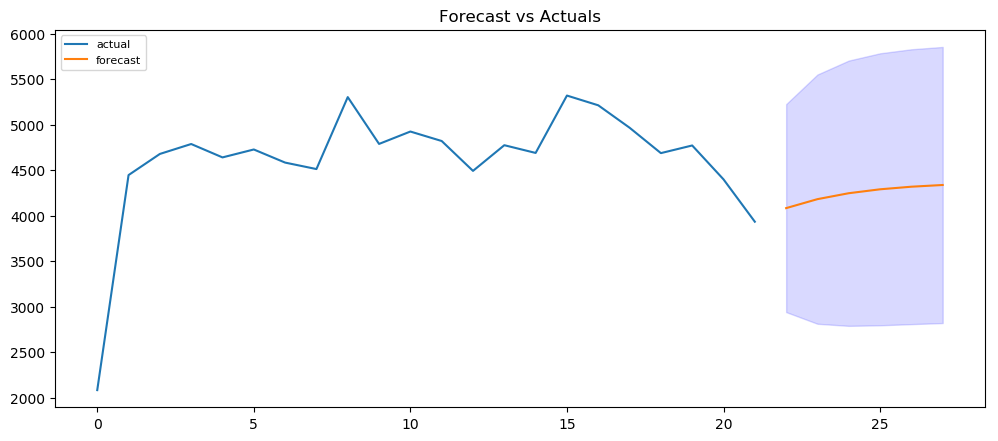

In [103]:
# Forecast
#fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf
l = len(pr['TX_ID'])

# Make as pandas series
fc_series = pd.Series(fc, index=fdf.index+l)
lower_series = pd.Series(conf[:, 0], index=fdf.index+l)
upper_series = pd.Series(conf[:, 1], index=fdf.index+l)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(pr['TX_ID'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='b', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [70]:
import numpy as np
import matplotlib.pyplot as plt

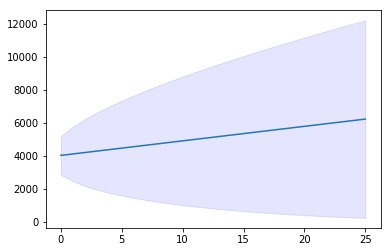

In [71]:
plt.plot(fc)
plt.fill_between(ci.index, 
                 (ci)[0], 
                 (ci)[1], color='b', alpha=.1)

In [74]:
os = pd.DataFrame(pr['TX_ID'])

In [75]:
os

,TX_ID
0,2085
1,4446
2,4678
3,4787
4,4640
5,4727
6,4583
7,4512
8,5302
9,4788


In [76]:
os["lw95"] = ""
os["hi95"] = ""

In [77]:
os

,TX_ID,lw95,hi95
0,2085,,
1,4446,,
2,4678,,
3,4787,,
4,4640,,
5,4727,,
6,4583,,
7,4512,,
8,5302,,
9,4788,,


In [65]:
fc = pd.DataFrame(fc)
new_data = os.append(fc, ignore_index=True)

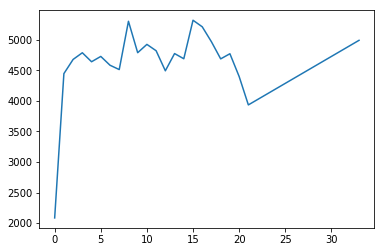

In [66]:
plt.plot(new_data)

In [104]:
y3 = [10, 8, 6, 4, 2, 0, 2, 4, 2, 0]
y3_upper = [11, 9, 7, 5, 3, 1, 3, 5, 3, 1]
y3_lower = [9, 7, 5, 3, 1, -.5, 1, 3, 1, -1]
y3_lower = y3_lower[::-1]


In [105]:
y3_lower

[-1, 1, 3, 1, -0.5, 1, 3, 5, 7, 9]

In [109]:
i = pr['TX_ID'].index
i

RangeIndex(start=0, stop=22, step=1)

In [110]:
i[::-1]

RangeIndex(start=21, stop=-1, step=-1)